In [ ]:
!pip install sklearn-crfsuite

In [2]:
import pickle
import json
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

processed_path = "/content/drive/MyDrive/NLP-POS/data/processed"

import os

!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-train.conllu -O train.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-dev.conllu   -O dev.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-test.conllu  -O test.conllu

Mounted at /content/drive


In [3]:
def read_conllu(path):
    sentences = []
    sent = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if sent:
                    sentences.append(sent)
                    sent = []
                continue
            if line.startswith("#"):
                continue
            cols = line.split("\t")
            if len(cols) != 10:
                continue

            token_id = cols[0]
            if "-" in token_id or "." in token_id:
                continue

            form = cols[1]
            upos = cols[3]
            sent.append((form, upos))
    if sent:
        sentences.append(sent)
    return sentences

train_sents = read_conllu("train.conllu")
dev_sents   = read_conllu("dev.conllu")
test_sents  = read_conllu("test.conllu")


In [4]:
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'word': word,
        'lower': word.lower(),
        'suffix3': word[-3:],
        'suffix2': word[-2:],
        'prefix1': word[0],
        'is_upper': word.isupper(),
        'is_title': word.istitle(),
        'is_digit': word.isdigit(),
    }

    if i > 0:
        word_prev = sent[i-1][0]
        features.update({
            '-1:word': word_prev,
            '-1:lower': word_prev.lower(),
            '-1:is_title': word_prev.istitle(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word_next = sent[i+1][0]
        features.update({
            '+1:word': word_next,
            '+1:lower': word_next.lower(),
            '+1:is_title': word_next.istitle(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [t for w, t in sent]


In [5]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_dev   = [sent2features(s) for s in dev_sents]
y_dev   = [sent2labels(s) for s in dev_sents]

X_test  = [sent2features(s) for s in test_sents]
y_test  = [sent2labels(s) for s in test_sents]


In [6]:
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [7]:
from sklearn_crfsuite import metrics

y_pred = crf.predict(X_test)

print("Accuracy:",
      metrics.flat_accuracy_score(y_test, y_pred))

print(metrics.flat_f1_score(y_test, y_pred,
                            average='weighted'))


Accuracy: 0.9523412764539243
0.9522443023663615


In [8]:
from sklearn_crfsuite import metrics

labels = list(crf.classes_)  # tüm POS tag'ler

print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=4
))


              precision    recall  f1-score   support

         ADV     0.9623    0.8991    0.9296       426
        PRON     0.9207    0.9248    0.9227       452
        VERB     0.9614    0.9368    0.9489      1170
         ADP     0.9920    0.9889    0.9905      1888
         DET     0.9888    0.9882    0.9885      1701
        NOUN     0.9569    0.9334    0.9450      2238
         ADJ     0.9035    0.8793    0.8912       671
       SCONJ     0.8847    0.9110    0.8977       337
       CCONJ     0.9730    0.9093    0.9401       397
       PUNCT     1.0000    0.9984    0.9992      1270
         NUM     0.9824    0.9696    0.9759       230
       PROPN     0.8008    0.9682    0.8766       818
         AUX     0.9355    0.9637    0.9494       331
           X     0.5417    0.2826    0.3714        46
         SYM     0.9167    0.8800    0.8980        25
        INTJ     0.0000    0.0000    0.0000         1
        PART     1.0000    1.0000    1.0000         1

    accuracy              

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


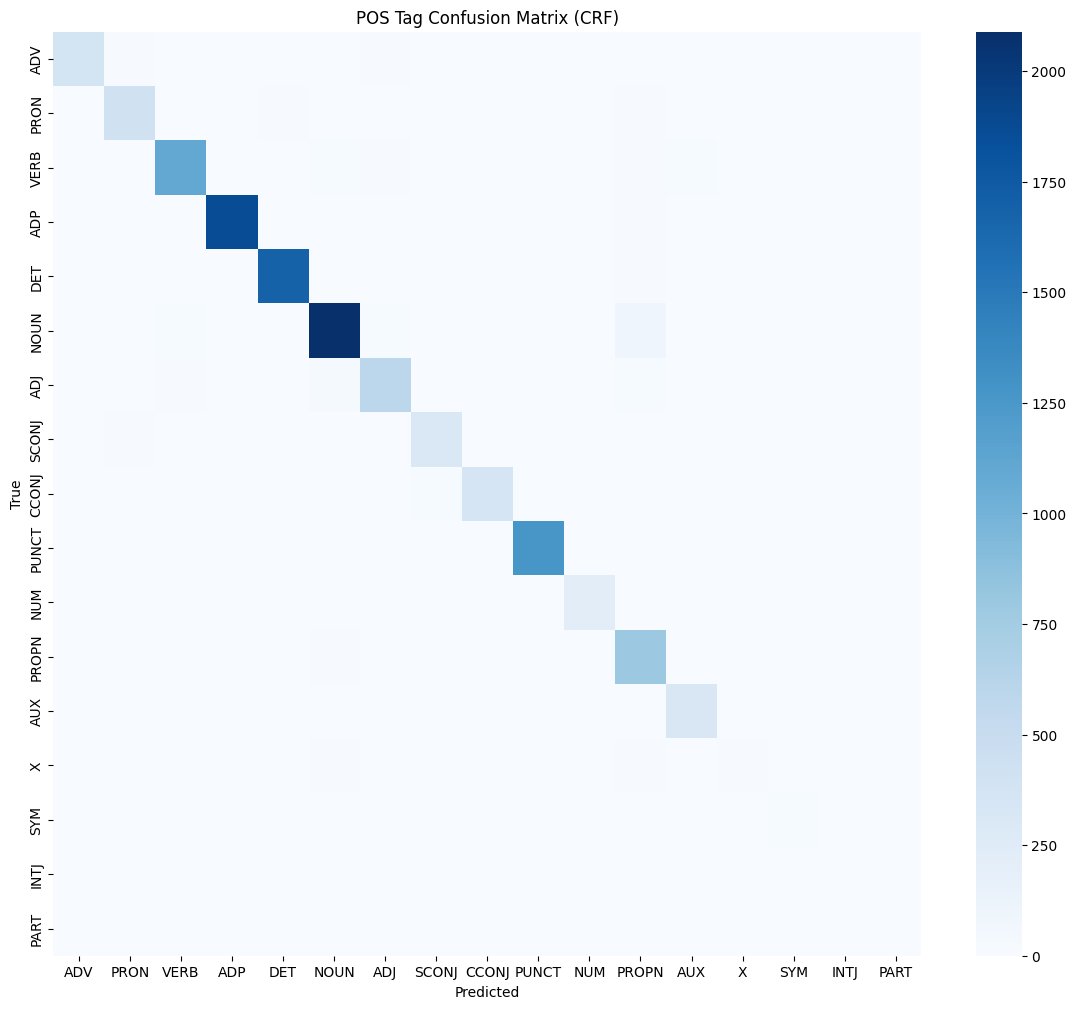

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten lists
y_true_flat = [t for sent in y_test for t in sent]
y_pred_flat = [t for sent in y_pred for t in sent]

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap="Blues", norm=None)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("POS Tag Confusion Matrix (CRF)")
plt.show()


In [10]:
def show_prediction(i):
    words = [w for w, t in test_sents[i]]
    true_tags = [t for w, t in test_sents[i]]
    pred_tags = y_pred[i]

    print("Cümle:", " ".join(words))
    print("\nKelime".ljust(15), "Gerçek".ljust(10), "Tahmin")
    print("-" * 40)

    for w, t_true, t_pred in zip(words, true_tags, pred_tags):
        print(w.ljust(15), t_true.ljust(10), t_pred)

# Örnek 0. cümleyi gösterelim
show_prediction(0)


Cümle: De allí procedía la familia de el escritor vallisoletano Blas Pajarero , cuya casa se encuentra en la Plaza de San Pedro ;

Kelime         Gerçek     Tahmin
----------------------------------------
De              ADP        ADP
allí            ADV        ADV
procedía        VERB       VERB
la              DET        DET
familia         NOUN       NOUN
de              ADP        ADP
el              DET        DET
escritor        NOUN       NOUN
vallisoletano   ADJ        ADJ
Blas            PROPN      PROPN
Pajarero        PROPN      PROPN
,               PUNCT      PUNCT
cuya            DET        DET
casa            NOUN       NOUN
se              PRON       PRON
encuentra       VERB       VERB
en              ADP        ADP
la              DET        DET
Plaza           PROPN      NOUN
de              ADP        ADP
San             PROPN      PROPN
Pedro           PROPN      PROPN
;               PUNCT      PUNCT


In [11]:
import pickle

with open("/content/drive/MyDrive/NLP-POS/models/crf_pos_model.pkl", "wb") as f:
    pickle.dump(crf, f)
